# SQL Server Connection Setup

In [163]:
# --- SQL Server Connection Test ---
import pyodbc
import pandas as pd

# STEP 1: Check available ODBC drivers
print("Available ODBC Drivers:")
for driver in pyodbc.drivers():
  print("   ", driver)

# STEP 2: Define connection details
server = "localhost\\SQL2022"              # Change if your instance name differs
database = "QuickStart_DataScience"        # Change to your database
driver = "SQL Server"                      # Use one listed above
#driver = "ODBC Driver 18 for SQL Server"  # Use one listed above
trusted_connection = "yes"                 # or "no" if using SQL auth
encrypt = "no"                             # disable encryption for local

conn_str = ( f"DRIVER={{{driver}}};"
             f"SERVER={server};"
             f"DATABASE={database};"
             f"Trusted_Connection={trusted_connection};"
             f"Encrypt={encrypt};" )

print("\nConnecting with:")
print(conn_str)

# STEP 3: Test connection and query
try:
  with pyodbc.connect(conn_str) as conn:
    query = "SELECT TOP 10 name, database_id FROM sys.databases ORDER BY name DESC;"
    df = pd.read_sql(query, conn)
    print("\nConnection successful! Sample query output:")
    display(df)
except Exception as e:
  print("\nConnection failed!")
  print(str(e))


Available ODBC Drivers:
    SQL Server
    ODBC Driver 17 for SQL Server
    ODBC Driver 18 for SQL Server
    Microsoft Access Driver (*.mdb, *.accdb)
    Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)
    Microsoft Access Text Driver (*.txt, *.csv)
    Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)

Connecting with:
DRIVER={SQL Server};SERVER=localhost\SQL2022;DATABASE=QuickStart_DataScience;Trusted_Connection=yes;Encrypt=no;

Connection successful! Sample query output:


C:\Users\randel.bjorkquist\AppData\Local\Temp\ipykernel_39112\4000086518.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,name,database_id
0,VideoGameCharacters,14
1,tempdb,2
2,ReportServerTempDB,9
3,ReportServer,8
4,QuickStart_DataScience,15
5,NZWalksAuth,13
6,NZWalks,12
7,msdb,4
8,model,3
9,master,1


<details>
<summary><strong>Database Connection Setup</strong></summary>

This code establishes a **connection between Python (via SQLAlchemy)** and a **local Microsoft SQL Server 2022 instance** named `SQL2022`, using **Windows Authentication** (trusted connection).  
- `create_engine(...)` defines a connection string to the **database** (`QuickStart_DataScience`) via the **ODBC Driver 18 for SQL Server**, using the **connection protocol** (`mssql+pyodbc`), **server** (`localhost\SQL2022`).
- The parameters `driver=ODBC Driver 18 for SQL Server`, `trusted_connection=yes`, and `Encrypt=no` configure how the connection is authenticated and secured.  
- Once created, the `engine` object can be passed to pandas functions such as `pd.read_sql()` to **execute SQL queries directly from Python** and **load results into a DataFrame** for analysis or visualization.

</details>

In [164]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine("mssql+pyodbc://localhost\\SQL2022/QuickStart_DataScience?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes&Encrypt=no")


In [165]:
# NOTE: 'engine' defined above ...

select_all_from_allstarfull   = "SELECT * FROM dbo.AllstarFull"
select_top10_from_allstarfull = "SELECT TOP 10 * FROM dbo.AllstarFull"

df = pd.read_sql(select_top10_from_allstarfull, engine)
df.head()


,playerID,yearID,gameNum,gameID,teamID,lgID,GP,startingPos
0,kalinal01,1957,0,NLS195707090,DET,AL,1,9
1,demaejo01,1957,0,NLS195707090,KC1,AL,0,None
2,grimbo01,1957,0,NLS195707090,NYA,AL,1,None
3,howarel01,1957,0,NLS195707090,NYA,AL,0,None
4,loesbi01,1957,0,NLS195707090,BAL,AL,1,None


# Project 3: Data Querying and Cleaning (SQL-Centric Version)

<details>
<summary><strong>Overview</strong></summary>

This version of **Project 3** emphasizes using **SQL** for data cleaning, transformation, and aggregation, while Python handles visualization and analysis.  
By leveraging SQL’s efficiency and relational structure, you ensure that Python receives clean, structured, and aggregated data that’s ready for analytics.

I’ve enhanced the database with a `deleted` bit column in each major table (`People`, `Appearances`, and `Batting`) to *soft delete* invalid or incomplete rows.  
This keeps the data historically intact while maintaining analytical integrity.

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Step 1: Data Cleaning with SQL</strong></summary>

### 1.1 Backup Original Tables
```sql
SELECT * INTO People_backup       FROM dbo.People;
SELECT * INTO Appearances_backup  FROM dbo.Appearances;
SELECT * INTO Batting_backup      FROM dbo.Batting;
```

### 1.2 Add `deleted` Column
```sql
ALTER TABLE dbo.People      ADD deleted BIT NOT NULL DEFAULT 0;
ALTER TABLE dbo.Appearances ADD deleted BIT NOT NULL DEFAULT 0;
ALTER TABLE dbo.Batting     ADD deleted BIT NOT NULL DEFAULT 0;
```

### 1.3 Flag Invalid Records
Soft-delete rows with missing or invalid key fields (e.g., missing name, birth date, stats):

```sql
UPDATE P
SET deleted = 1
FROM dbo.People P
WHERE P.deleted = 0
  AND (P.playerID IS NULL OR
       P.birthYear IS NULL OR
       P.nameFirst IS NULL OR
       P.nameLast IS NULL OR
       P.weight IS NULL);
```
Apply similar rules to `Batting` and `Appearances`. Records remain in the database but are **excluded from analytics** using `WHERE deleted = 0`.

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Step 2: Data Extraction and Transformation with SQL</strong></summary>

### 2.1. Common Table Expressions (CTEs)

The query defines three key CTEs:

#### `active_players_2018`

Filters for **active players** whose `finalGame` is after 2017-12-31 (or
null, defaulting to current date). Ensures the player is not deleted and
enriches player data with calculated fields.

``` sql
active_players_2018 AS (
  SELECT 
     PL.*
    ,TRIM(AP.nameFirst) + ' ' + TRIM(AP.nameLast) AS 'playerName'
    ,DATEDIFF(YEAR, DATEFROMPARTS(AP.birthYear, AP.birthMonth, AP.birthDay), GETDATE())
      - CASE 
          WHEN MONTH(GETDATE()) < AP.birthMonth OR
              MONTH(GETDATE()) = AP.birthMonth AND 
                DAY(GETDATE()) < AP.birthDay 
          THEN 1 ELSE 0 
        END AS 'playerAge'
  FROM 
    dbo.People AS PL
  WHERE 
    PL.deleted = 0
    AND ISNULL(PL.finalGame, GETDATE()) > '2017/12/31'
)
```

#### `eligibile_players`

Identifies players who have appeared in **at least 50 games** by summing
their `G_all` appearances across all teams and seasons. Deleted
appearances are excluded.

``` sql
eligibile_players AS (
  SELECT 
    AP.playerID
  FROM 
    dbo.Appearances AS AP
  WHERE 
    AP.deleted = 0
  GROUP BY 
    AP.playerID
  HAVING 
    SUM(CAST(AP.G_all AS INT)) >= 50
)
```

#### `batting_stats`

Aggregates each player's **batting stats per year**, combining multiple
`stint` entries (e.g., from mid-season trades) into a single record per
year.\

``` sql
batting_stats AS (
  SELECT
     B.playerID,
     B.yearID,
     SUM(CAST(G       AS INT))  AS       'G',
     SUM(CAST(AB      AS INT))  AS      'AB',
     SUM(CAST(R       AS INT))  AS       'R',
     SUM(CAST(H       AS INT))  AS       'H',
     SUM(CAST(_2B     AS INT))  AS     '_2B',
     SUM(CAST(_3B     AS INT))  AS     '_3B',
     SUM(CAST(HR      AS INT))  AS      'HR',
     SUM(CAST(RBI     AS INT))  AS     'RBI',
     SUM(CAST(SB      AS INT))  AS      'SB',
     SUM(CAST(CS      AS INT))  AS      'CS',
     SUM(CAST(BB      AS INT))  AS      'BB',
     SUM(CAST(SO      AS INT))  AS      'SO',
     SUM(CAST(IBB     AS INT))  AS     'IBB',
     SUM(CAST(HBP     AS INT))  AS     'HBP',
     SUM(CAST(SH      AS INT))  AS      'SH',
     SUM(CAST(SF      AS INT))  AS      'SF',
     SUM(CAST(GIDP    AS INT))  AS    'GIDP'
  FROM 
    dbo.Batting AS B
  WHERE 
    B.deleted = 0
  GROUP BY 
     B.playerID
    ,B.yearID
)
```

**What this does**
- Includes only non-deleted, active players (post‑2017)
- Requires ≥ 50 games played (eligibility)
- Aggregates all batting stats to 1 row per player‑year (handles trades ' stints')
- Returns player metadata, calculated age, and stats

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Step 3: Analytical Queries & Visualizations</strong></summary>

### 1A. Player with Most RBI (2015–2018)
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT TOP 10
   AP.playerID
  ,TRIM(AP.nameFirst) + ' ' + TRIM(AP.nameLast) AS playerName
  ,SUM(B.RBI) AS totalRBI
FROM
  active_players_2018       AS AP
    JOIN eligibile_players  AS EP 
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
WHERE
  BS.yearID BETWEEN 2015 AND 2018
GROUP BY
   AP.playerID
  ,AP.playerName
ORDER BY 
  totalRBI DESC;
```

### 1B. Albert Pujols — GIDP in 2016
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT 
   AP.playerName
  ,BS.yearID
  ,BS.GIDP
FROM
  active_players_2018       AS AP
    JOIN eligibile_players  AS EP
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
    ON AP.playerID = EP.playerID
WHERE 
  BS.yearID = 2016
  AND AP.playerName = 'Pujols Albert'
GROUP BY
  B.yearID;
```

### 2A. Histogram of Triples per Year (SQL summary for Python)
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT
    B.yearID,
    SUM(B.[3B]) AS totalTriples
FROM 
  active_players_2018       AS AP
    JOIN eligibile_players  AS EP 
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
GROUP BY
  BS.yearID
ORDER BY
  BS.yearID;
```

### 2B. Scatter Plot — Triples vs Steals (player‑year)
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT
   AP.playerID
  ,AP.playerName
  ,B.yearID
  ,B._3B AS '3B'
  ,B.SB
FROM active_players_2018    AS AP
    JOIN eligibile_players  AS EP 
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
ORDER BY
  B.yearID;
```

*Python examples for plotting:*
```python
# Histogram of Triples per Year (from the yearly summary df)
df.plot(kind='bar', x='yearID', y='totalTriples', title='Triples per Year')

# Scatter: Triples vs Steals (from player-year df)
plt.scatter(df['3B'], df['SB'])
plt.xlabel('Triples')
plt.ylabel('Stolen Bases')
plt.title('Relationship between Triples and Steals')
```

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Step 4: Additional Analytical Questions</strong></summary>

### (1) Highest Batting Average in 2018
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT TOP 10
   AP.playerName
  ,CAST(B.H AS FLOAT) / NULLIF(B.AB, 0) AS 'BA'
FROM 
  active_players_2018       AS AP
    JOIN eligibile_players  AS EP 
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
WHERE 
  BS.yearID = 2018
ORDER BY
  BA DESC;
```

### (2) Walks vs Strikeouts by Year (for correlation)
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT
   B.yearID
  ,SUM(B.BB)
  ,SUM(B.SO)
FROM 
  active_players_2018       AS AP
    JOIN eligibile_players  AS EP 
      JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
GROUP BY
  BS.yearID
ORDER BY
  BS.yearID;
```
*Python:* `plt.scatter(df['totalWalks'], df['totalStrikeouts'])`

### (3) Largest HR Increase from 2017 → 2018
```sql
;WITH active_players_2018 AS (...), eligibile_players AS (...), non_deleted_batting AS (...)
SELECT
   AP.playerID
  ,AP.playerName
  ,SUM(CASE WHEN yearID = 2018 THEN BS.HR ELSE 0 END) - 
   SUM(CASE WHEN yearID = 2017 THEN BS.HR ELSE 0 END) AS 'HR_Improvement'
FROM
  active_players                AS AP
    INNER JOIN eligible_players AS EP
      INNER JOIN batting_stats  AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
GROUP BY
   AP.playerID
  ,AP.playerName
ORDER BY
  HR_Improvement DESC;
```

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Summary</strong></summary>

**SQL handles**
- Data validation with `deleted` soft‑deletes  
- Eligibility & active‑player filters  
- Per‑player, per‑year aggregation (trade‑safe)  
- Computed fields (age, concatenated name)

**Python handles**
- Plotting and EDA (histograms, scatter, correlation)  
- Answer formatting and presentation in the notebook

This SQL‑first workflow keeps Python focused on insights, not data wrangling.

</details>


### Full SQL command with CTEs and final SELECT, 'valid' data only


In [166]:
# 'engine' defined above ...
full_sql_command = """
;WITH active_players AS (
  SELECT
     P.*
    ,TRIM(P.nameFirst) + ' ' + TRIM(P.nameLast) AS playerName
    ,DATEDIFF(YEAR, DATEFROMPARTS(P.birthYear, P.birthMonth, P.birthDay), GETDATE())
      - CASE 
          WHEN MONTH(GETDATE()) < P.birthMonth OR
              MONTH(GETDATE())  = P.birthMonth AND 
                DAY(GETDATE())  < P.birthDay 
          THEN 1 ELSE 0 
        END AS 'playerAge'    
  FROM
    dbo.People AS P
  WHERE
    P.deleted = 0 AND 
    ISNULL(P.finalGame, GETDATE()) > '2017/12/31'
),
eligible_players AS (
  SELECT
    A.playerID
  FROM
    dbo.Appearances AS A
  WHERE
    A.deleted = 0
  GROUP BY
    A.playerID
  HAVING
    SUM(CAST(A.G_all AS INT)) >= 50
),
batting_stats AS (
  SELECT
     B.playerID
    ,B.yearID
    ,SUM(CAST(G       AS INT))  AS    'G'
    ,SUM(CAST(AB      AS INT))  AS   'AB'
    ,SUM(CAST(R       AS INT))  AS    'R'
    ,SUM(CAST(H       AS INT))  AS    'H'
    ,SUM(CAST(_2B     AS INT))  AS  '_2B'
    ,SUM(CAST(_3B     AS INT))  AS  '_3B'
    ,SUM(CAST(HR      AS INT))  AS   'HR'
    ,SUM(CAST(RBI     AS INT))  AS  'RBI'
    ,SUM(CAST(SB      AS INT))  AS   'SB'
    ,SUM(CAST(CS      AS INT))  AS   'CS'
    ,SUM(CAST(BB      AS INT))  AS   'BB'
    ,SUM(CAST(SO      AS INT))  AS   'SO'
    ,SUM(CAST(IBB     AS INT))  AS  'IBB'
    ,SUM(CAST(HBP     AS INT))  AS  'HBP'
    ,SUM(CAST(SH      AS INT))  AS   'SH'
    ,SUM(CAST(SF      AS INT))  AS   'SF'
    ,SUM(CAST(GIDP    AS INT))  AS 'GIDP'
  FROM
    Batting AS B
  WHERE    
    B.deleted = 0
  GROUP BY
     B.playerID
    ,B.yearID
  HAVING
    SUM(CAST(B.G AS INT)) >= 50
)
SELECT
   AP.playerID
  ,AP.playerName
  ,AP.[weight]
  ,AP.throws
  ,AP.playerAge
  ,AP.birthCountry
  ,AP.birthState
  ,AP.birthCity
  ,BS.yearID
  ,BS.G
  ,BS.AB
  ,BS.R
  ,BS.H
  ,BS._2B AS '2B'
  ,BS._3B AS '3B'
  ,BS.HR
  ,BS.RBI
  ,BS.SB
  ,BS.CS
  ,BS.BB
  ,BS.SO
  ,BS.IBB
  ,BS.HBP
  ,BS.SH
  ,BS.SF
  ,BS.GIDP
FROM active_players AS AP
  INNER JOIN eligible_players AS EP
    INNER JOIN batting_stats AS BS
      ON EP.playerID = BS.playerID
    ON AP.playerID = EP.playerID
ORDER BY 
   AP.playerID  ASC
  ,BS.yearID    DESC;
"""

df = pd.read_sql(full_sql_command, engine)
df.head(25)


,playerID,playerName,weight,throws,playerAge,birthCountry,birthState,birthCity,yearID,G,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2016,57,...,0,0,0,0,1,0,0,0,0,0
1,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2015,62,...,0,0,0,0,0,0,0,0,0,0
2,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2014,69,...,0,0,0,0,0,0,0,0,0,0
3,abramcj01,CJ Abrams,185,R,25,USA,GA,Alpharetta,2023,151,...,64,47,4,32,118,2,13,3,3,7
4,abramcj01,CJ Abrams,185,R,25,USA,GA,Alpharetta,2022,90,...,21,7,4,5,50,0,9,2,2,5
5,abreubr01,Bryan Abreu,225,R,28,D.R.,Distrito Nacional,Santo Domingo,2023,72,...,0,0,0,0,0,0,0,0,0,0
6,abreubr01,Bryan Abreu,225,R,28,D.R.,Distrito Nacional,Santo Domingo,2022,55,...,0,0,0,0,0,0,0,0,0,0
7,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2023,141,...,90,0,1,42,130,1,6,0,6,16
8,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2022,157,...,75,0,0,62,110,2,12,0,4,19
9,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2021,152,...,117,1,0,61,143,3,22,0,10,28


### Common Table Expressions (CTEs)
This illustrates how to separate CTEs for reuse. In different code cells below, SELECT statements \
are defined, using these same CTEs, without having to redefine them, and allowing the developer to \
focus specifially on what they want to accomplish and not how to pull or define the base data.

In [167]:
# IMPORTANT: this code cell, defines and separates the CTEs from the 'full_sql_command' above.
CTEs = """
;WITH active_players AS (
  SELECT
     P.*
    ,TRIM(P.nameFirst) + ' ' + TRIM(P.nameLast) AS playerName
    ,DATEDIFF(YEAR, DATEFROMPARTS(P.birthYear, P.birthMonth, P.birthDay), GETDATE())
      - CASE 
        WHEN MONTH(GETDATE()) < P.birthMonth OR
             MONTH(GETDATE()) = P.birthMonth AND 
               DAY(GETDATE()) < P.birthDay 
        THEN 1 ELSE 0 
      END AS 'playerAge'
  FROM
    dbo.People AS P
  WHERE
    P.deleted = 0 AND 
    ISNULL(P.finalGame, GETDATE()) > '2017/12/31'
),
eligible_players AS (
  SELECT
    A.playerID
  FROM
    dbo.Appearances AS A
  WHERE
    A.deleted = 0
  GROUP BY
    A.playerID
  HAVING
    SUM(CAST(A.G_all AS INT)) >= 50
),
batting_stats AS (
  SELECT
     B.playerID
    ,B.yearID
    ,SUM(CAST(G       AS INT))  AS    'G'
    ,SUM(CAST(AB      AS INT))  AS   'AB'
    ,SUM(CAST(R       AS INT))  AS    'R'
    ,SUM(CAST(H       AS INT))  AS    'H'
    ,SUM(CAST(_2B     AS INT))  AS  '_2B'
    ,SUM(CAST(_3B     AS INT))  AS  '_3B'
    ,SUM(CAST(HR      AS INT))  AS   'HR'
    ,SUM(CAST(RBI     AS INT))  AS  'RBI'
    ,SUM(CAST(SB      AS INT))  AS   'SB'
    ,SUM(CAST(CS      AS INT))  AS   'CS'
    ,SUM(CAST(BB      AS INT))  AS   'BB'
    ,SUM(CAST(SO      AS INT))  AS   'SO'
    ,SUM(CAST(IBB     AS INT))  AS  'IBB'
    ,SUM(CAST(HBP     AS INT))  AS  'HBP'
    ,SUM(CAST(SH      AS INT))  AS   'SH'
    ,SUM(CAST(SF      AS INT))  AS   'SF'
    ,SUM(CAST(GIDP    AS INT))  AS 'GIDP'
  FROM
    Batting AS B
  WHERE    
    B.deleted = 0
  GROUP BY
     B.playerID
    ,B.yearID
  HAVING
    SUM(CAST(B.G AS INT)) >= 50
)
"""

In [168]:
#'engine' AND 'CTEs' are defined above, this code cell focuses on a simple SELECT statement example.
select = """
SELECT
   AP.playerID
  ,AP.playerName
  ,AP.[weight]
  ,AP.throws
  ,AP.playerAge
  ,AP.birthCountry
  ,AP.birthState
  ,AP.birthCity
  ,BS.yearID
  ,BS.G
  ,BS.AB
  ,BS.R
  ,BS.H
  ,BS._2B AS '2B'
  ,BS._3B AS '3B'
  ,BS.HR
  ,BS.RBI
  ,BS.SB
  ,BS.CS
  ,BS.BB
  ,BS.SO
  ,BS.IBB
  ,BS.HBP
  ,BS.SH
  ,BS.SF
  ,BS.GIDP
FROM active_players AS AP
  INNER JOIN eligible_players AS EP
    INNER JOIN batting_stats AS BS
      ON EP.playerID = BS.playerID
    ON AP.playerID = EP.playerID
ORDER BY 
   AP.playerID  ASC
  ,BS.yearID    DESC;
"""

command = CTEs + select

df = pd.read_sql(command, engine)
df.head(25)

,playerID,playerName,weight,throws,playerAge,birthCountry,birthState,birthCity,yearID,G,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2016,57,...,0,0,0,0,1,0,0,0,0,0
1,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2015,62,...,0,0,0,0,0,0,0,0,0,0
2,abadfe01,Fernando Abad,235,L,39,D.R.,La Romana,La Romana,2014,69,...,0,0,0,0,0,0,0,0,0,0
3,abramcj01,CJ Abrams,185,R,25,USA,GA,Alpharetta,2023,151,...,64,47,4,32,118,2,13,3,3,7
4,abramcj01,CJ Abrams,185,R,25,USA,GA,Alpharetta,2022,90,...,21,7,4,5,50,0,9,2,2,5
5,abreubr01,Bryan Abreu,225,R,28,D.R.,Distrito Nacional,Santo Domingo,2023,72,...,0,0,0,0,0,0,0,0,0,0
6,abreubr01,Bryan Abreu,225,R,28,D.R.,Distrito Nacional,Santo Domingo,2022,55,...,0,0,0,0,0,0,0,0,0,0
7,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2023,141,...,90,0,1,42,130,1,6,0,6,16
8,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2022,157,...,75,0,0,62,110,2,12,0,4,19
9,abreujo02,Jose Abreu,235,R,38,Cuba,Cienfuegos,Cienfuegos,2021,152,...,117,1,0,61,143,3,22,0,10,28


### Retrieves the Players having the TOP 10 RBIs for 2015 through 2018.

In [169]:
#'engine' AND 'CTEs' are defined above ...
rbis_for_2015_through_2018 = """
SELECT TOP 10
   AP.playerName                AS 'Player Name'
  ,SUM(CAST(BS.RBI AS INT))     AS 'Total RBIs'
FROM active_players             AS AP
  INNER JOIN eligible_players   AS EP
    INNER JOIN batting_stats    AS BS
      ON EP.playerID = BS.playerID
    ON AP.playerID = EP.playerID
WHERE
  BS.yearID BETWEEN 2015 AND 2018
GROUP BY
   AP.PlayerName
  ,AP.playerID
ORDER BY
    [Total RBIs] DESC
"""

RBIs = CTEs + rbis_for_2015_through_2018

df = pd.read_sql(RBIs, engine)
df.head(10)

,Player Name,Total RBIs
0,Nolan Arenado,503
1,Edwin Encarnacion,452
2,Anthony Rizzo,420
3,Nelson Cruz,414
4,Paul Goldschmidt,408
5,J. D. Martinez,404
6,Khris Davis,401
7,Manny Machado,384
8,Jose Abreu,381
9,Albert Pujols,379


### Retrieves Albert Pujols' GIDP (Grounded Into Double Plays) stat for 2016

In [170]:
#'engine' AND 'CTEs' are defined above ...
albert_pujols_2016_gidp = """
SELECT
   AP.playerName              AS 'Player Name'
  ,BS.yearID                  AS 'Year' 
  ,BS.GIDP                    AS 'GIDPs'
FROM
  active_players                AS AP
    INNER JOIN eligible_players AS EP
      INNER JOIN batting_stats  AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
WHERE
  AP.playerName = 'Albert Pujols'
  AND BS.yearID = 2016
"""

GIDPs = CTEs + albert_pujols_2016_gidp

df = pd.read_sql(GIDPs, engine)
df.head(10)

,Player Name,Year,GIDPs
0,Albert Pujols,2016,24


### Retrieves the total number of triples per year

<Axes: title={'center': 'Total Triples per Year (Active Players with ≥50 Games)'}, xlabel='Year', ylabel='Total Triples'>

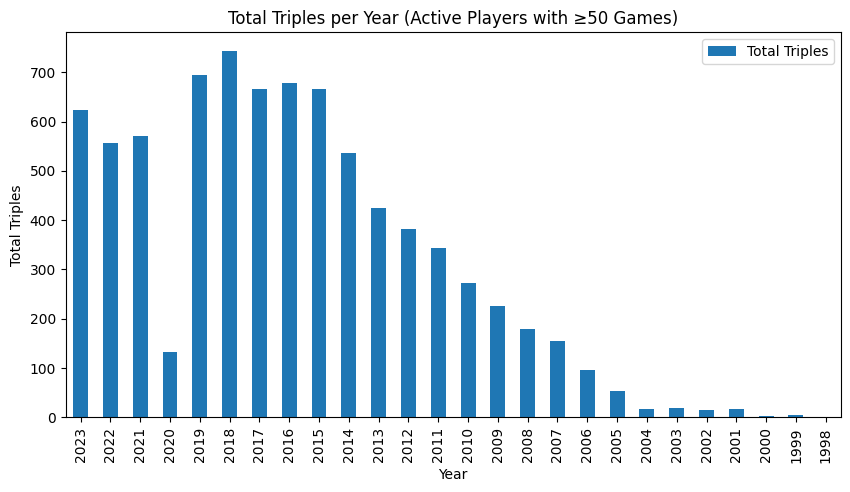

In [171]:
#'engine' AND 'CTEs' are defined above ...
triples_per_year = """
SELECT
   BS.yearID      AS 'Year'
  ,SUM(BS._3B)    AS 'Total Triples'
FROM
  active_players                  AS AP
    INNER JOIN eligible_players   AS EP 
      INNER JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
GROUP BY
  BS.yearID
ORDER BY
  BS.yearID DESC;
"""

triples = CTEs + triples_per_year

df = pd.read_sql(triples, engine)
df.plot.bar( x = 'Year'
            ,y = 'Total Triples'
            ,title  = 'Total Triples per Year (Active Players with ≥50 Games)'
            ,xlabel = 'Year'
            ,ylabel = 'Total Triples'
            ,figsize=(10,5))


### Retrieves and plots triples vs stolen bases for active players

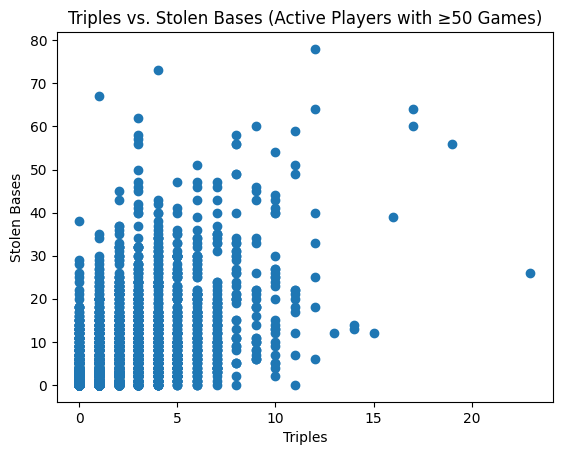

In [172]:
#'engine' AND 'CTEs' are defined above ...
triples_vs_steals = """
SELECT
   AP.playerName    AS 'Player Name'
  ,BS.yearID        AS 'Year'
  ,BS._3B           AS 'Triples'
  ,BS.SB            AS 'Stolen Bases'
FROM
  active_players                  AS AP
    INNER JOIN eligible_players   AS EP 
      INNER JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
ORDER BY
  BS.yearID ASC;
"""

triplesVSsteals = CTEs + triples_vs_steals

df = pd.read_sql(triplesVSsteals, engine)

#NOTE: matplotlib imported for plotting and visualization
from matplotlib import pyplot as plt

plt.scatter( df['Triples'], df['Stolen Bases'] )
plt.title('Triples vs. Stolen Bases (Active Players with ≥50 Games)')
plt.xlabel('Triples')
plt.ylabel('Stolen Bases')

plt.show()


### Retrieves the TOP 10 Batting Averages for 2018

In [173]:
#'engine' AND 'CTEs' are defined above ...
top10_2018_batting_averages = """
SELECT TOP 10
  AP.playerName                                         AS 'Player Name'
 ,CAST(BS.H AS FLOAT) / NULLIF(CAST(BS.AB AS FLOAT), 0) AS 'BA'
 ,BS.AB                                                 AS 'AB'
FROM
  active_players AS AP
    INNER JOIN eligible_players AS EP
      INNER JOIN batting_stats AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
WHERE
  BS.yearID = 2018
  AND BS.AB >= 100
ORDER BY
   BA    DESC
  ,BS.AB DESC;
"""

battingAverages = CTEs + top10_2018_batting_averages

df = pd.read_sql(battingAverages, engine)
df.head(10)


,Player Name,BA,AB
0,Mookie Betts,0.346154,520
1,J. D. Martinez,0.330404,569
2,Jeff McNeil,0.328889,225
3,Christian Yelich,0.325784,574
4,Jose Altuve,0.316479,534
5,Justin Turner,0.312329,365
6,Mike Trout,0.312102,471
7,Scooter Gennett,0.309932,584
8,Freddie Freeman,0.309061,618
9,Michael Brantley,0.308772,570


### Retrieves and plots the total walks vs strikeouts per year

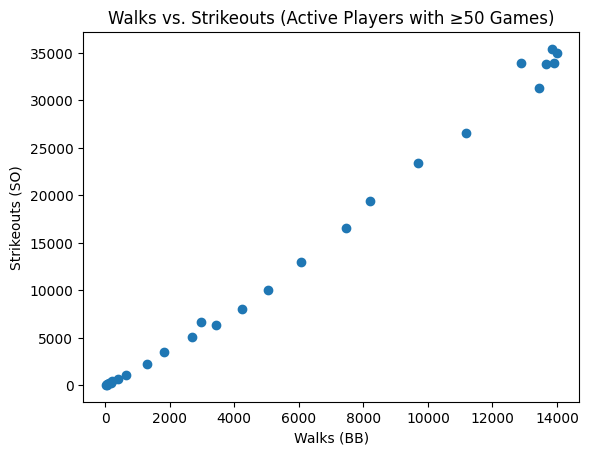

In [174]:
#'engine' AND 'CTEs' are defined above ...
bbVSso = """
SELECT
   BS.yearID  AS 'Year'
  ,SUM(BS.BB) AS 'Total BB'
  ,SUM(BS.SO) AS 'Total SO'
FROM
  active_players                  AS AP
    INNER JOIN eligible_players   AS EP 
      INNER JOIN batting_stats    AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
GROUP BY
  BS.yearID
ORDER BY
  BS.yearID DESC;
"""

walksVSstrikeouts = CTEs + bbVSso
df = pd.read_sql(walksVSstrikeouts, engine)

plt.scatter( df['Total BB'], df['Total SO'] )
plt.title('Walks vs. Strikeouts (Active Players with ≥50 Games)')
plt.xlabel('Walks (BB)') 
plt.ylabel('Strikeouts (SO)')
plt.show()

### Retrieves the TOP 10 most improved players from 2022 to 2023
- HR (Home Runs) are the measure

In [175]:
#'engine' AND 'CTEs' are defined above ...
most_improved_players = """
SELECT TOP 10
   AP.playerName                                      AS 'Player Name'
  ,SUM(CASE WHEN yearID = 2023 THEN BS.HR ELSE 0 END) AS 'HRs in 2023'
  ,SUM(CASE WHEN yearID = 2022 THEN BS.HR ELSE 0 END) AS 'HRs in 2022'
  ,SUM(CASE WHEN yearID = 2023 THEN BS.HR ELSE 0 END) - 
   SUM(CASE WHEN yearID = 2022 THEN BS.HR ELSE 0 END) AS 'Improvement'
FROM
  active_players                AS AP
    INNER JOIN eligible_players AS EP
      INNER JOIN batting_stats  AS BS
        ON EP.playerID = BS.playerID
      ON AP.playerID = EP.playerID
WHERE
  BS.yearID IN (2022, 2023)
  AND BS.AB >= 100
GROUP BY
   AP.playerName
HAVING  
  SUM(CASE WHEN yearID = 2022 THEN BS.HR ELSE 0 END) > 0
ORDER BY
  Improvement DESC;
"""

most_improved = CTEs + most_improved_players

df = pd.read_sql(most_improved, engine)
df


,Player Name,HRs in 2023,HRs in 2022,Improvement
0,Jake Burger,34,8,26
1,Ronald Acuna,41,15,26
2,Jorge Soler,36,13,23
3,Spencer Torkelson,31,8,23
4,Matt Olson,54,34,20
5,Jose Siri,25,7,18
6,Josh Lowe,20,2,18
7,J. D. Martinez,33,16,17
8,Marcell Ozuna,40,23,17
9,CJ Abrams,18,2,16


# Project 3: Data Querying and Cleaning (Python-Centric Version)

<details>
<summary><strong>What this version does</strong></summary>

This approach keeps SQL minimal and performs **cleaning, feature engineering, filtering, and aggregation in Python**.  
We pull “raw-ish” rows from the three tables, then use **pandas** to:

- Soft-delete “bad” rows by constructing a `deleted` flag in Python (instead of SQL).
- Define **active players** using `finalGame > 2017-12-31` (treating null as “still active”).
- Define **eligible players** (≥ 50 games via `Appearances.G_all`).
- Aggregate **Batting** to **player-year** (sum across stints/teams).
- Build calculated columns (`playerName`, `playerAge`) and join demographics.

Finally, we answer the required questions and produce the required plots.

</details>

<!-- ---------------------------------------------------------------------------------------------------------------------------------------- -->

<details>
<summary><strong>Setup & Minimal Reads (SQL kept simple)</strong></summary>

```python
from datetime import datetime
import pandas as pd
from sqlalchemy import create_engine

# 1) Connect (example: Windows auth to local SQL 2022)
engine = create_engine(
  "mssql+pyodbc://localhost\\SQL2022/QuickStart_DataScience?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes&Encrypt=no"
)

# 2) Minimal queries (no server-side cleaning/aggregation)
people = pd.read_sql("""
SELECT
  P.*
FROM
  dbo.People AS P
ORDER BY
  P.playerID ASC;
""", engine)

appearances = pd.read_sql("""
SELECT
   A.*
FROM
  dbo.Appearances AS A
ORDER BY
   A.yearID ASC
  ,A.teamID ASC
  ,A.playerID ASC;"
""", engine)

batting = pd.read_sql("""
SELECT 
  B.* 
FROM
  dbo.Batting AS B
ORDER BY
   B.playerID ASC
  ,B.yearID   ASC;
""", engine)


### SELECT all data from the 'People' table.
- To simplify the SQL script which retrieves data from the 'People' table, I've decided to perform a SELECT * (SELECT ALL) and drop the 'deleted' column.
- The 'deleted' column, used above in the **SQL-Centric Version**, is a true/false flag indicating which rows are considered 'valid'.

In [176]:
#'engine' defined above ...
select_people = """
SELECT 
  P.* 
FROM
  dbo.People AS P
ORDER BY
   P.playerID ASC;
"""

people = pd.read_sql(select_people, engine)
people = people.drop(columns = ['deleted'])
people

,ID,playerID,birthYear,birthMonth,birthDay,birthCity,birthCountry,birthState,deathYear,deathMonth,...,nameLast,nameGiven,weight,height,bats,throws,debut,bbrefID,finalGame,retroID
0,1,aardsda01,1981.0,12,27,Denver,USA,CO,None,None,...,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,aardsda01,2015-08-23,aardd001
1,2,aaronha01,1934.0,2,5,Mobile,USA,AL,2021,1,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,aaronha01,1976-10-03,aaroh101
2,3,aaronto01,1939.0,8,5,Mobile,USA,AL,1984,8,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,aaronto01,1971-09-26,aarot101
3,4,aasedo01,1954.0,9,8,Orange,USA,CA,None,None,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,aasedo01,1990-10-03,aased001
4,5,abadan01,1972.0,8,25,Palm Beach,USA,FL,None,None,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,abadan01,2006-04-13,abada001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21005,20672,zupofr01,1939.0,8,29,San Francisco,USA,CA,2005,3,...,Zupo,Frank Joseph,182.0,71.0,L,R,1957-07-01,zupofr01,1961-05-09,zupof101
21006,20673,zuvelpa01,1958.0,10,31,San Mateo,USA,CA,None,None,...,Zuvella,Paul,173.0,72.0,R,R,1982-09-04,zuvelpa01,1991-05-02,zuvep001
21007,20674,zuverge01,1924.0,8,20,Holland,USA,MI,2014,9,...,Zuverink,George,195.0,76.0,R,R,1951-04-21,zuverge01,1959-06-15,zuveg101
21008,20675,zwilldu01,1888.0,11,2,St. Louis,USA,MO,1978,3,...,Zwilling,Edward Harrison,160.0,66.0,L,L,1910-08-14,zwilldu01,1916-07-12,zwild101


### SELECT all data from the 'Appearances' table.
- Above, in the **SQL-Centric Version**, this table is used to find which Players are considered 'eligible'.
- To be considered 'eligible', a Player must have appeared in a minimum of 50 games.
  * [Appearances].[G_all] >= 50
- **NOTE:** another option might be to count the number of games (G) in the 'Batting' table.
  * [Batting].[G] >= 50
- Also, just like the 'People' table, the 'deleted' column is a true/false flag indicating which rows are \
  considered 'valid' and is being dropped for the same reason, minimal/simplified SQL script.

In [177]:
#'engine' defined above ...
select_appearances = """
SELECT 
  A.*
FROM
  dbo.Appearances AS A
ORDER BY
   A.yearID   ASC
  ,A.teamID   ASC
  ,A.playerID ASC;
"""

appearances = pd.read_sql(select_appearances, engine)
appearances = appearances.drop(columns = ['deleted'])
appearances

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,BS1,NA,barnero01,31,31,31,31,0,0,...,16,0,15,0,0,0,0,0,0,0
1,1871,BS1,NA,barrofr01,18,17,18,18,0,0,...,1,0,0,13,0,4,17,0,0,0
2,1871,BS1,NA,birdsda01,29,29,29,29,0,7,...,0,0,0,0,0,27,27,0,0,0
3,1871,BS1,NA,conefr01,19,18,19,19,0,0,...,0,0,0,18,0,1,19,0,0,0
4,1871,BS1,NA,gouldch01,31,31,31,31,0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113715,2023,WAS,NL,wardth01,26,0,0,26,26,0,...,0,0,0,0,0,0,0,0,0,0
113716,2023,WAS,NL,weemsjo01,51,0,0,51,51,0,...,0,0,0,0,0,0,0,0,0,0
113717,2023,WAS,NL,william01,18,0,0,18,18,0,...,0,0,0,0,0,0,0,0,0,0
113718,2023,WAS,NL,willitr01,30,30,0,30,30,0,...,0,0,0,0,0,0,0,0,0,0


### SELECT all data from the 'Batting' table.
- The 'deleted' column, a true/false flag indicating which rows are considered 'valid', just like above is being
  dropped so a minimal/simplifed SQL script can be used to retrieve data from the 'Batting' table.
- **NOTE**: I know the project documentation does not say anything about how many at bats 'qualify' a Player to be
  considered while comparing, but I believe a minimum of 100 AB (At Bats) should level the playing fields. \
  * Example: when comparing the increase in BAs (Batting Averages) or the number of HRs (Home Runs), for Players with
  0 (zero) or lower than a minium AB (At Bats), aren't even with players having 4x-5x the minimum number of AB (At 
  Bats).

In [178]:
#'engine' defined above ...
select_batting = """
SELECT 
  B.* 
FROM
  dbo.Batting AS B
ORDER BY
   B.playerID ASC
  ,B.yearID   ASC;
"""

batting = pd.read_sql(select_batting, engine)
batting = batting.drop(columns = ['deleted'])
batting


,playerID,yearID,stint,teamID,lgID,G,G_batting,AB,R,H,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,G_old
0,aardsda01,2004,1,SFN,NL,11,None,0,0,0,...,0,0,0,0,0,0,0,0,0,None
1,aardsda01,2006,1,CHN,NL,45,None,2,0,0,...,0,0,0,0,0,0,1,0,0,None
2,aardsda01,2007,1,CHA,AL,25,None,0,0,0,...,0,0,0,0,0,0,0,0,0,None
3,aardsda01,2008,1,BOS,AL,47,None,1,0,0,...,0,0,0,1,0,0,0,0,0,None
4,aardsda01,2009,1,SEA,AL,73,None,0,0,0,...,0,0,0,0,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113794,zwilldu01,1915,1,CHF,FL,150,None,548,65,157,...,24,None,67,65,None,2,18,None,None,None
113795,zwilldu01,1916,1,CHN,NL,35,None,53,4,6,...,0,None,4,6,None,0,2,None,None,None
113796,zychto01,2015,1,SEA,AL,13,None,0,0,0,...,0,0,0,0,0,0,0,0,0,None
113797,zychto01,2016,1,SEA,AL,12,None,0,0,0,...,0,0,0,0,0,0,0,0,0,None


### Cleaning & Feature Engineering in 'pandas'



#### Validate required fields in the *People* table and flag invalid rows

- This step defines a helper function that inspects each row of the **People** table and checks whether all required fields are present.  
- We maintain a list of essential columns (name, birth details, handedness, etc.) and mark the row as **deleted = True** if *any* of those fields are missing (`NaN`).  
- This creates a soft-delete mask similar to SQL logic, letting us filter out invalid player records in later steps without modifying the underlying database.


In [179]:
def is_bad_people(row):
    must_have = [ #identity
                  "playerID"
                 
                 # birth information
                 ,"birthYear", "birthMonth", "birthDay"
                 ,"birthCity", "birthCountry", "birthState"

                 # name fields
                 ,"nameFirst", "nameLast"
                 
                 # physical /handedness attributes
                 ,"weight", "bats", "throws"]
    
    return any(pd.isna(row[c]) for c in must_have)

# ADD 'deleted' COLUMN TO people DATAFRAME
people["deleted"] = people.apply(is_bad_people, axis = 1)

# Import Jupyter's rich display function so we can show multiple outputs
# (e.g., numbers, DataFrames) in the same cell with proper formatting.
from IPython.display import display

#NOTE: returns '2,022': the same count as within SQL Server
display(f"deleted rows: {people['deleted'].sum()}")
display(people)

'deleted rows: 2022'

,ID,playerID,birthYear,birthMonth,birthDay,birthCity,birthCountry,birthState,deathYear,deathMonth,...,nameGiven,weight,height,bats,throws,debut,bbrefID,finalGame,retroID,deleted
0,1,aardsda01,1981.0,12,27,Denver,USA,CO,None,None,...,David Allan,215.0,75.0,R,R,2004-04-06,aardsda01,2015-08-23,aardd001,False
1,2,aaronha01,1934.0,2,5,Mobile,USA,AL,2021,1,...,Henry Louis,180.0,72.0,R,R,1954-04-13,aaronha01,1976-10-03,aaroh101,False
2,3,aaronto01,1939.0,8,5,Mobile,USA,AL,1984,8,...,Tommie Lee,190.0,75.0,R,R,1962-04-10,aaronto01,1971-09-26,aarot101,False
3,4,aasedo01,1954.0,9,8,Orange,USA,CA,None,None,...,Donald William,190.0,75.0,R,R,1977-07-26,aasedo01,1990-10-03,aased001,False
4,5,abadan01,1972.0,8,25,Palm Beach,USA,FL,None,None,...,Fausto Andres,184.0,73.0,L,L,2001-09-10,abadan01,2006-04-13,abada001,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21005,20672,zupofr01,1939.0,8,29,San Francisco,USA,CA,2005,3,...,Frank Joseph,182.0,71.0,L,R,1957-07-01,zupofr01,1961-05-09,zupof101,False
21006,20673,zuvelpa01,1958.0,10,31,San Mateo,USA,CA,None,None,...,Paul,173.0,72.0,R,R,1982-09-04,zuvelpa01,1991-05-02,zuvep001,False
21007,20674,zuverge01,1924.0,8,20,Holland,USA,MI,2014,9,...,George,195.0,76.0,R,R,1951-04-21,zuverge01,1959-06-15,zuveg101,False
21008,20675,zwilldu01,1888.0,11,2,St. Louis,USA,MO,1978,3,...,Edward Harrison,160.0,66.0,L,L,1910-08-14,zwilldu01,1916-07-12,zwild101,False


#### Validate required fields in the *Batting* table and flag invalid rows

- The Batting table contains per-player, per-year, per-stint performance data.  
- To ensure we only analyze complete and reliable records, we define a validation function that checks all essential batting statistic fields (games, hits, at-bats, doubles, triples, HR, RBI, etc.).  

If *any* required field is missing for a row, it is marked as `deleted = True`, creating a soft-delete mask that allows us to exclude incomplete batting records from all downstream aggregations.


In [180]:
def is_bad_batting(row):
    must_have = [# identifiers
                 "playerID", "yearID", "stint", "teamID", "lgID"

                 # core batting counts
                 ,"G", "AB", "R", "H"

                 #hit types
                 ,"_2B", "_3B", "HR"

                 # run & stolen base contributes
                 ,"RBI", "SB", "CS"

                 # plate discipline
                 ,"BB", "SO", "IBB", "HBP"

                 # sacrifices
                 ,"SH", "SF"
                 
                 # double plays grounded into
                 ,"GIDP"]
    return any(pd.isna(row[c]) for c in must_have)

# ADD 'deleted' COLUMN TO batting DATAFRAME
batting["deleted"] = batting.apply(is_bad_batting, axis = 1)

#NOTE: returns '36,680': the same count as within SQL Server
display(f"deleted rows: {batting['deleted'].sum()}")
display(batting)

'deleted rows: 36680'

,playerID,yearID,stint,teamID,lgID,G,G_batting,AB,R,H,...,CS,BB,SO,IBB,HBP,SH,SF,GIDP,G_old,deleted
0,aardsda01,2004,1,SFN,NL,11,None,0,0,0,...,0,0,0,0,0,0,0,0,None,False
1,aardsda01,2006,1,CHN,NL,45,None,2,0,0,...,0,0,0,0,0,1,0,0,None,False
2,aardsda01,2007,1,CHA,AL,25,None,0,0,0,...,0,0,0,0,0,0,0,0,None,False
3,aardsda01,2008,1,BOS,AL,47,None,1,0,0,...,0,0,1,0,0,0,0,0,None,False
4,aardsda01,2009,1,SEA,AL,73,None,0,0,0,...,0,0,0,0,0,0,0,0,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113794,zwilldu01,1915,1,CHF,FL,150,None,548,65,157,...,None,67,65,None,2,18,None,None,None,True
113795,zwilldu01,1916,1,CHN,NL,35,None,53,4,6,...,None,4,6,None,0,2,None,None,None,True
113796,zychto01,2015,1,SEA,AL,13,None,0,0,0,...,0,0,0,0,0,0,0,0,None,False
113797,zychto01,2016,1,SEA,AL,12,None,0,0,0,...,0,0,0,0,0,0,0,0,None,False


#### Validate required fields in the *Appearances* table and flag invalid rows

- The Appearances table records how many games a player appears at each position for a given team and season.  
- To keep only complete and reliable records, we define a validation function that checks key identifying fields (year, team, league, player) and positional game counts (total games, batting, pitching, catching, infield, outfield, DH).  
 
If *any* of these required columns is missing for a row, it is marked as `deleted = True`, giving us a soft-delete mask to exclude incomplete appearance records from later analysis.


In [181]:
def is_bad_appearances(row):
    must_have = [
        # identifiers
        "yearID", "teamID", "lgID", "playerID",

        # overall & batting games
        "G_all", "G_batting",

        # battery (pitcher / catcher)
        "G_p", "G_c",

        # infield positions
        "G_1b", "G_2b", "G_3b", "G_ss",

        # outfield positions + DH
        "G_lf", "G_cf", "G_rf", "G_of", "G_dh"
    ]

    return any(pd.isna(row[c]) for c in must_have)

# ADD 'deleted' COLUMN TO appearances DATAFRAME
appearances["deleted"] = appearances.apply(is_bad_appearances, axis = 1)

#NOTE: returns '1,264': the same count as within SQL Server
display(f"deleted rows: {appearances['deleted'].sum()}")
display(appearances)

'deleted rows: 1264'

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,deleted
0,1871,BS1,NA,barnero01,31,31,31,31,0,0,...,0,15,0,0,0,0,0,0,0,False
1,1871,BS1,NA,barrofr01,18,17,18,18,0,0,...,0,0,13,0,4,17,0,0,0,False
2,1871,BS1,NA,birdsda01,29,29,29,29,0,7,...,0,0,0,0,27,27,0,0,0,False
3,1871,BS1,NA,conefr01,19,18,19,19,0,0,...,0,0,18,0,1,19,0,0,0,False
4,1871,BS1,NA,gouldch01,31,31,31,31,0,0,...,0,0,0,0,1,1,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113715,2023,WAS,NL,wardth01,26,0,0,26,26,0,...,0,0,0,0,0,0,0,0,0,False
113716,2023,WAS,NL,weemsjo01,51,0,0,51,51,0,...,0,0,0,0,0,0,0,0,0,False
113717,2023,WAS,NL,william01,18,0,0,18,18,0,...,0,0,0,0,0,0,0,0,0,False
113718,2023,WAS,NL,willitr01,30,30,0,30,30,0,...,0,0,0,0,0,0,0,0,0,False


#### Identify 'active' players based on `finalGame` (Python version of `active_players_2018`)

In the SQL version, the `active_players_2018` CTE treats a player as *active* if their `finalGame` date is **after 2017-12-31**, and also treats a missing `finalGame` as if it were “today” using `ISNULL(finalGame, GETDATE())`.

Here, we mirror that logic in pandas:

- Convert `finalGame` to a datetime.
- Replace missing `finalGame` values with today’s date so they count as still active.
- Keep only rows where:
  - `deleted == False` (passed our earlier validation), and  
  - effective `finalGame` > 2017-12-31.

The result is stored in `active_players_2018`, which is the Python equivalent of the SQL `active_players_2018` CTE.

**Additional Notes (calculated fields):**
- As required by the project instructions, we add two calculated columns:
  - `playerName` — created by concatenating `nameFirst` and `nameLast`.
  - `playerAge` — computed from `birthYear`, `birthMonth`, and `birthDay`.
- After these are created, the original name fields (`nameFirst`, `nameLast`) and birth fields (`birthYear`, `birthMonth`, `birthDay`) are dropped from `active_players_2018` since they are no longer needed.
- Raw birth date components are retained so the age calculation remains traceable and reproducible.


In [182]:
cutoff = pd.Timestamp("2017-12-31")

# Convert 'finalGame' to datetime, treating invalid/missing values, coerce errors to NaT
final_game = pd.to_datetime(people["finalGame"], errors = "coerce")

# Missor SQL: ISNULL(P.finalGame, GETDATE()) > '2017/12/31'
final_game_filled = final_game.fillna(pd.Timestamp.today())

active_mask = (~people["deleted"]) & (final_game_filled > cutoff)
#active_players_2018 = people.loc[active_mask].copy()
active_players_2018 = people.loc[ active_mask
                                 ,[ "playerID"
                                   ,"nameFirst"
                                   ,"nameLast"
                                   ,"birthYear"
                                   ,"birthMonth"
                                   ,"birthDay"
                                   ,"birthCountry"
                                   ,"birthState"
                                   ,"birthCity"
                                   ,"weight"
                                   ,"throws" ]].copy()

#NOTE: returns '2,837': the same count as within SQL Server
display(active_players_2018)


,playerID,nameFirst,nameLast,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,weight,throws
5,abadfe01,Fernando,Abad,1985.0,12,17,D.R.,La Romana,La Romana,235.0,L
10,abbotan01,Andrew,Abbott,1999.0,6,1,USA,VA,Lynchburg,192.0,L
11,abbotco01,Cory,Abbott,1995.0,9,20,USA,CA,San Diego,220.0,R
33,abramcj01,CJ,Abrams,2000.0,10,3,USA,GA,Alpharetta,185.0,R
36,abreual01,Albert,Abreu,1995.0,9,26,D.R.,Monte Cristi,Guayubin,190.0,R
...,...,...,...,...,...,...,...,...,...,...,...
20980,zimmery01,Ryan,Zimmerman,1984.0,9,28,USA,NC,Washington,215.0,R
20993,zobribe01,Ben,Zobrist,1981.0,5,26,USA,IL,Eureka,210.0,R
20999,zuberty01,Tyler,Zuber,1995.0,6,16,USA,AR,White Hall,175.0,R
21002,zuniggu01,Guillermo,Zu�iga,1998.0,10,10,Colombia,Bolivar,Cartagena,230.0,R


In [183]:

today = pd.Timestamp.today().normalize()

def calc_age(y, m, d):
  try:
    b = pd.Timestamp(int(y), int(m), int(d))
    return (today.year - b.year) - int((today.month, today.day) < (b.month, b.day))
  except Exception:
    return pd.NA

# Build 'playerName' by concatenating first and last names with a space
active_players_2018["playerName"] = ( active_players_2018["nameFirst"].str.strip()
                                     + " "
                                     + active_players_2018["nameLast"].str.strip())

# Calculate 'playerAge' using the 'calc_age' function
active_players_2018["playerAge"] = active_players_2018.apply( lambda r: calc_age(r["birthYear"], r["birthMonth"], r["birthDay"])
                                                             ,axis = 1 )

# Drop first/last name fields after building 'playerName', as well as birth date fields after calculating 'playerAge'
active_players_2018 = active_players_2018.drop(columns = ["nameFirst", "nameLast", "birthYear", "birthMonth", "birthDay"])

display(active_players_2018)

,playerID,birthCountry,birthState,birthCity,weight,throws,playerName,playerAge
5,abadfe01,D.R.,La Romana,La Romana,235.0,L,Fernando Abad,39
10,abbotan01,USA,VA,Lynchburg,192.0,L,Andrew Abbott,26
11,abbotco01,USA,CA,San Diego,220.0,R,Cory Abbott,30
33,abramcj01,USA,GA,Alpharetta,185.0,R,CJ Abrams,25
36,abreual01,D.R.,Monte Cristi,Guayubin,190.0,R,Albert Abreu,30
...,...,...,...,...,...,...,...,...
20980,zimmery01,USA,NC,Washington,215.0,R,Ryan Zimmerman,41
20993,zobribe01,USA,IL,Eureka,210.0,R,Ben Zobrist,44
20999,zuberty01,USA,AR,White Hall,175.0,R,Tyler Zuber,30
21002,zuniggu01,Colombia,Bolivar,Cartagena,230.0,R,Guillermo Zu�iga,27


#### Identity 'eligible' players on `G_all` (Python version of `eligible_players`)

The project requires us to consider only players who have appeared in at least **50 games**.  
To mirror the SQL logic, we:

- Start from the cleaned `Appearances` data (rows where `deleted == False`).
- Fill any missing `G_all` values with 0 and treat them as integers.
- Group by `playerID` and sum `G_all` to get each player’s total games played across all teams and seasons.
- Keep only players with a total `G_all` of **50 or more**, and store their IDs in an `eligible_players` DataFrame that has one row per eligible player.

**Code Notes:**
- We use `groupby(..., as_index=False)` so that `playerID` remains a regular column instead of becoming an index.  
  This makes downstream merging and filtering easier and keeps the DataFrame consistent with SQL-style output.
- We use `.loc[row_filter, column_list]` to explicitly select only the rows where the player has ≥ 50 total games *and* only the `playerID` column.  
  This avoids keeping unnecessary aggregated columns and makes the intent of the filtering step clear.

In [184]:
player_total_games = (appearances[~appearances["deleted"]]
                        .assign(G_all = lambda df: df["G_all"].fillna(0).astype("Int64"))
                        .groupby("playerID", as_index = False)["G_all"]
                        .sum())

eligible_players = player_total_games.loc[ player_total_games["G_all"] >= 50
                                          ,["playerID"]]

#NOTE: returns '11,874': the same count as within SQL Server
print(eligible_players)

        playerID
0      aardsda01
1      aaronha01
2      aaronto01
3       aasedo01
5       abadfe01
...          ...
20524  zupcibo01
20526  zuvelpa01
20527  zuverge01
20528  zwilldu01
20529   zychto01

[11874 rows x 1 columns]


#### Aggregate Batting Statistics (Python version of `batting_stats`)

This step collapses multiple Batting rows for the same player in the same year into a single yearly stat line.  
This is important for players who were traded mid-season and therefore have separate rows for each team and stint.

- We start from the cleaned `batting` data (rows where `deleted == False`).
- We ensure all key batting stat columns are non-null integers so they can be safely summed.
- We then group by `playerID` and `yearID` and sum the numeric batting columns, producing one row per player per year with combined totals across all teams/stints.

**Code Notes:**
- The `groupby(["playerID", "yearID"], as_index=False)` keeps `playerID` and `yearID` as regular columns instead of turning them into an index, which makes later merges and filtering easier.
- Only the columns in `num_cols` are aggregated; all other columns (like `teamID`, `stint`) are intentionally not carried forward, since their meaning becomes ambiguous once we’ve combined multiple rows into a single yearly record.


In [185]:
num_cols = [# core batting counts
            "G", "AB", "R", "H"
            #hit types
            ,"_2B", "_3B", "HR"
            # run & stolen base contributes
            ,"RBI", "SB", "CS"
            # plate discipline
            ,"BB", "SO", "IBB", "HBP"
            # sacrifices
            ,"SH", "SF"
            
            # double plays grounded into
            ,"GIDP"]

batting_clean = batting[~batting["deleted"]].copy()

for c in num_cols:
    batting_clean[c] = batting_clean[c].fillna(0).astype(int)

batting_stats = (batting_clean
                    .groupby(["playerID","yearID"], as_index = False)[num_cols]
                    .sum())
#NOTE: returns '71,086': the same count as within SQL Server
batting_stats

,playerID,yearID,G,AB,R,H,_2B,_3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,aardsda01,2004,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,aardsda01,2006,45,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,aardsda01,2007,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,aardsda01,2008,47,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,aardsda01,2009,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71081,zuverge01,1958,45,9,0,2,0,1,0,2,0,0,1,2,0,0,0,0,0
71082,zuverge01,1959,6,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
71083,zychto01,2015,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71084,zychto01,2016,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Join: 'active' and 'eligible' and 'batting_stats'

We now combine the cleaned, player-level and batting-level data into a single DataFrame:

- First, we inner-join `active_players_2018` with `eligible_players` on `playerID` to keep only players who are both **active** and have appeared in at least 50 games.  
  This result (`ae`) remains at the player level and includes `playerName`, `playerAge`, and other player attributes.
- Next, we inner-join `ae` with `batting_stats` on `playerID`.  
  Since `batting_stats` is at the (playerID, yearID) grain, the final DataFrame `df` has one row per **player-year**, combining player attributes with aggregated batting statistics.


In [186]:
# Merge active players with eligible players (intersection on 'playerID')
ae = active_players_2018.merge(eligible_players, on = "playerID", how = "inner")

# Merge the result with batting statistics (intersection on 'playerID')
df = ae.merge(batting_stats, on = "playerID", how = "inner")

print(df)

        playerID birthCountry birthState   birthCity  weight throws  \
0       abadfe01         D.R.  La Romana   La Romana   235.0      L   
1       abadfe01         D.R.  La Romana   La Romana   235.0      L   
2       abadfe01         D.R.  La Romana   La Romana   235.0      L   
3       abadfe01         D.R.  La Romana   La Romana   235.0      L   
4       abadfe01         D.R.  La Romana   La Romana   235.0      L   
...          ...          ...        ...         ...     ...    ...   
11982  zuninmi01          USA         FL  Cape Coral   235.0      R   
11983  zuninmi01          USA         FL  Cape Coral   235.0      R   
11984  zuninmi01          USA         FL  Cape Coral   235.0      R   
11985  zuninmi01          USA         FL  Cape Coral   235.0      R   
11986  zuninmi01          USA         FL  Cape Coral   235.0      R   

          playerName  playerAge  yearID    G  ...  RBI  SB  CS  BB   SO  IBB  \
0      Fernando Abad         39    2010   22  ...    0   0   0   0 

### Retrieves the Players having the TOP 10 RBIs for 2015 through 2018

In [187]:
top10_rbi_2015_2018 = ( df[df["yearID"].between(2015, 2018)]
                          .groupby(["playerID", "playerName"], as_index=False)["RBI"]
                          .sum()
                          .sort_values("RBI", ascending=False)
                          .drop(columns=["playerID"])
                          .rename(columns={ "playerName": "Player Name"
                                           ,"RBI": "Total RBIs" })
                          .head(10)
)

top10_rbi_2015_2018

,Player Name,Total RBIs
47,Nolan Arenado,503
314,Edwin Encarnacion,452
914,Anthony Rizzo,420
240,Nelson Cruz,414
413,Paul Goldschmidt,408
676,J. D. Martinez,404
257,Khris Davis,401
653,Manny Machado,384
1,Jose Abreu,381
874,Albert Pujols,379


### Retrieves Albert Pujols' GIDP (Grounded Into Double Plays) stat for 2016

In [188]:
albert_pujols_2016_gidp = (df[(df["playerName"] == "Albert Pujols") & (df["yearID"] == 2016)]
                            .loc[:, ["playerName", "yearID", "GIDP"]]
                            .rename( columns = { "playerName": "Player Name"
                                                , "yearID": "Year"
                                                , "GIDP": "GIDPs" }))

albert_pujols_2016_gidp

,Player Name,Year,GIDPs
8603,Albert Pujols,2016,24


### Retrieves the total number of triples per year

<Axes: title={'center': 'Total Triples per Year (Active Players with ≥ 50 Games)'}, xlabel='Year', ylabel='Total Triples'>

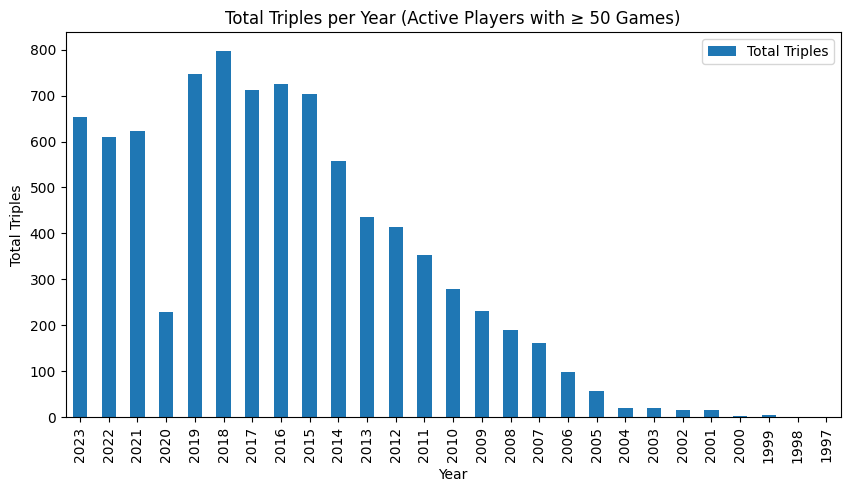

In [189]:
# 1. Aggregate triples (_3B) by year
triples_per_year = (df.groupby("yearID", as_index=False)["_3B"]
                      .sum()
                      .sort_values("yearID", ascending = False)
                      .rename(columns={"yearID": "Year", "_3B": "Total Triples"}))

# 2. Plot as bar chart
triples_per_year.plot.bar( x = "Year"
                          ,y = "Total Triples"
                          ,title  = "Total Triples per Year (Active Players with ≥ 50 Games)"
                          ,xlabel = "Year"
                          ,ylabel = "Total Triples"
                          ,figsize=(10,5))

### Retrieves and plot triples vs stolen bases for active players

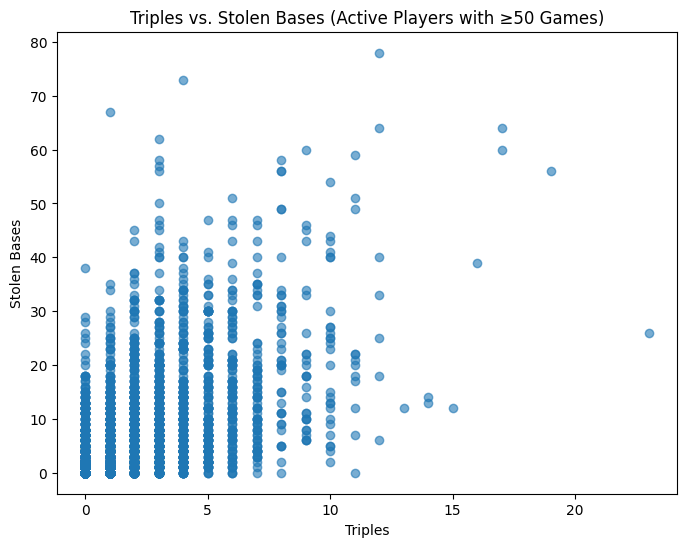

In [190]:
# Scatter plot: Triples vs Stolen Bases

# Keep only rows where both stats exist (they should in your cleaned df)
scatter_df = df[["_3B", "SB"]].rename( columns = { "_3B": "Triples"
                                                  ,"SB": "Stolen Bases" })

from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter( scatter_df["Triples"]
            ,scatter_df["Stolen Bases"]
            ,alpha = 0.6 )

plt.title("Triples vs. Stolen Bases (Active Players with ≥50 Games)")
plt.xlabel("Triples")
plt.ylabel("Stolen Bases")

plt.show()


### Retrieves the TOP 10 batting averages for 2018

In [191]:
ba_2018 = (df[(df["yearID"] == 2018) & (df["AB"] >= 100)]
            .assign(BA=lambda d: d["H"] / d["AB"]))

top10_ba_2018 = ( ba_2018.sort_values( ["BA", "AB"]
                                      ,ascending = [False, False] )
                         .loc[:, ["playerName", "BA", "AB"]]
                         .rename(columns = {"playerName": "Player Name"})
                         .head(10) )

# Optional: round batting average to 3 decimal places for display
#top10_ba_2018["BA"] = top10_ba_2018["BA"].round(3)

top10_ba_2018



,Player Name,BA,AB
957,Mookie Betts,0.346154,520
6635,J. D. Martinez,0.330404,569
6981,Jeff McNeil,0.328889,225
11859,Christian Yelich,0.325784,574
11304,Luke Voit,0.321678,143
284,Jose Altuve,0.316479,534
10989,Justin Turner,0.312329,365
10915,Mike Trout,0.312102,471
2726,Yandy Diaz,0.311927,109
3848,Scooter Gennett,0.309932,584


### Retrieves and plot the total walks vs strikeouts per year

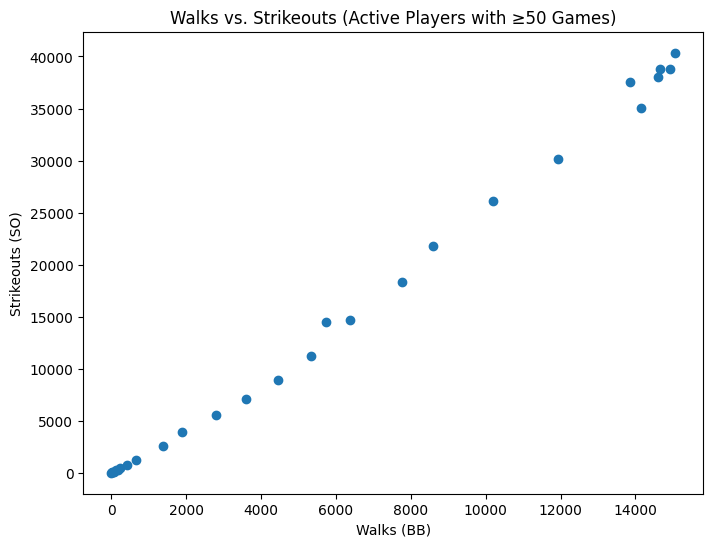

In [192]:
# 1) Aggregate walks (BB) and strikeouts (SO) by year
bb_so_per_year = ( df.groupby( "yearID", as_index = False)[["BB", "SO"]]
                     .sum()
                     .rename(columns = { "yearID": "Year"
                                        ,"BB": "Total BB"
                                        ,"SO": "Total SO" })
                     .sort_values("Year", ascending = False))

bb_so_per_year

# 2) Scatter plot: Total Walks vs Total Strikeouts per year
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter( bb_so_per_year["Total BB"]
            ,bb_so_per_year["Total SO"])

plt.title("Walks vs. Strikeouts (Active Players with ≥50 Games)")
plt.xlabel("Walks (BB)")
plt.ylabel("Strikeouts (SO)")

plt.show()


### Retrieves the TOP 10 most improved players from 2022 to 2023
- HR (Home Runs) are the measure

In [193]:
# 1) Filter to 2022 & 2023, with AB ≥ 100
hr_base = (df[(df["yearID"].isin([2022, 2023])) & (df["AB"] >= 100)]
            .groupby(["playerID", "playerName", "yearID"], as_index = False)["HR"]
            .sum())

# 2) Pivot to wide format: one row per player, HR_2022 and HR_2023 as columns
hr_wide = (hr_base.pivot_table( index = ["playerID", "playerName"]
                               ,columns = "yearID"
                               ,values = "HR"
                               ,fill_value = 0)
                  .reset_index()
)

# Remove the columns name for clarity; otherwise it shows as 'yearID' in the output
hr_wide.columns.name = None

# 3) Rename year columns for clarity
hr_wide = hr_wide.rename( columns = { 2022: "HR_2022"
                                     ,2023: "HR_2023" })

# 4) Compute improvement and filter out players with 0 HR in 2022 (baseline)
hr_wide["Improvement"] = hr_wide["HR_2023"] - hr_wide["HR_2022"]
improved = hr_wide[hr_wide["HR_2022"] > 0]

# 5) Sort by Improvement and take top 10
top10_improved_hr = ( improved.sort_values("Improvement", ascending=False)
                              .loc[:, ["playerName", "HR_2023", "HR_2022", "Improvement"]]
                              .rename(columns = { "playerName": "Player Name"
                                                 ,"HR_2022": "HRs in 2022"
                                                 ,"HR_2023": "HRs in 2023" })
                              .head(10))

top10_improved_hr

,Player Name,HRs in 2023,HRs in 2022,Improvement
67,Jake Burger,34.0,8.0,26.0
2,Ronald Acuna,41.0,15.0,26.0
211,Gunnar Henderson,28.0,4.0,24.0
458,Spencer Torkelson,31.0,8.0,23.0
424,Jorge Soler,36.0,13.0,23.0
86,Corbin Carroll,25.0,4.0,21.0
337,Matt Olson,54.0,34.0,20.0
416,Jose Siri,25.0,7.0,18.0
263,Josh Lowe,20.0,2.0,18.0
341,Marcell Ozuna,40.0,23.0,17.0
